Primeiramente, importa-se os módulos e as classes que serao usadas ao longo da análise.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

E, agora, importa-se o dataset que será usado. O dataset "heart" contém informaçoes sobre pacientes, seus respcetivos problemas cardíacos e uma classificaçao sobre apresentar ou nao uma doença cardíaca.

In [5]:
heart = pd.read_csv("heart.csv")
heart.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [7]:
heart.tail(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
908,63,M,ASY,140,187,0,LVH,144,Y,4.0,Up,1
909,63,F,ASY,124,197,0,Normal,136,Y,0.0,Flat,1
910,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
911,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


Começa-se pré processando os dados. Antes de tudo, vê-se se há missing values no dataset.

In [6]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Nao há valores faltantes, porém percebe-se a presença de diversas features de dados categóricos(Sex, ChestPain, RestingECG, etc) e, logo, a necessidade de realizar One-Hot-Enconding, tornando-as features numéricas - o que nos permite aplicar algoritmos como Logistical Regression, uma vez que este é o objetivo desta análise.

In [8]:
heart["ExerciseAngina"] = heart["ExerciseAngina"].replace(['N','Y'],[0,1]) # Uma vez que esta feature já é binária.

c_features = heart.select_dtypes(include='object').columns

for feature in c_features:
  ohe = OneHotEncoder(handle_unknown='ignore')

  columns = heart[feature].unique()
  columns.sort()
  columns = [feature +' - '+ x for x in columns]
  
  ohe_df = pd.DataFrame(ohe.fit_transform(heart[[feature]]).toarray(), columns= columns)
  heart = heart.join(ohe_df)

heart.drop(columns = c_features, inplace=True)
heart


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex - F,Sex - M,ChestPainType - ASY,ChestPainType - ATA,ChestPainType - NAP,ChestPainType - TA,RestingECG - LVH,RestingECG - Normal,RestingECG - ST,ST_Slope - Down,ST_Slope - Flat,ST_Slope - Up
0,40,140,289,0,172,0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,0,1.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,0,108,1,1.5,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,150,195,0,122,0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,0,1.2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
914,68,144,193,1,141,0,3.4,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
915,57,130,131,0,115,1,1.2,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
916,57,130,236,0,174,0,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Entretanto, os dados nao estao na mesma escala, logo há a necessidade de normalizá-los. Além disso, algoritmos como PCA somente funcionam eficazmente em dados normalizados.

In [9]:
scaler = StandardScaler()

y = heart.HeartDisease.to_numpy()
heart.drop(columns="HeartDisease", inplace=True)
x = scaler.fit_transform(heart.to_numpy())

print(f'O desvio padrao nas features é {np.std(x)} e a média é {np.mean(x)}.')

O desvio padrao nas features é 1.0 e a média é 3.014571863676609e-17.


Ou seja, desvio padrao 1 e média extremamente próxima de 0, asssim como esperado.

Agora, pode-se aplicar PCA e analizá-lo.

[]

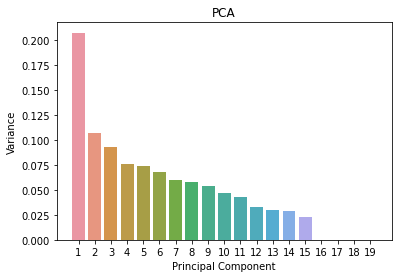

In [13]:
pca = PCA().fit(x)
variance = pca.explained_variance_ratio_

sns.barplot(x = np.arange(1,len(variance)+1),y = variance)
plt.title("PCA")
plt.xlabel("Principal Component")
plt.ylabel("Variance")
plt.plot()

Em seguida, a variancia acumulada.

[]

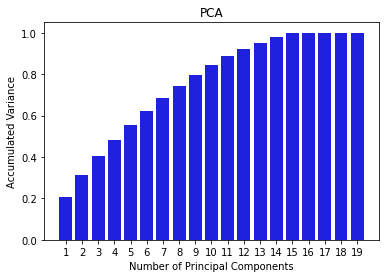

In [14]:
acc_variance = np.cumsum(variance)

sns.barplot(x = np.arange(1,len(acc_variance)+1),y = acc_variance, color = "blue")
plt.title("PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Variance")
plt.plot()

Assim, percebe-se que toda a variancia dos dados é representada até o PC15, e que a partir do 12 já é possível representar 90%. Ou seja, pode-se sem perda reduzir a dimensionalidade destes dados de 19 para 15 e com perda moderada de 19 para 12.

[]

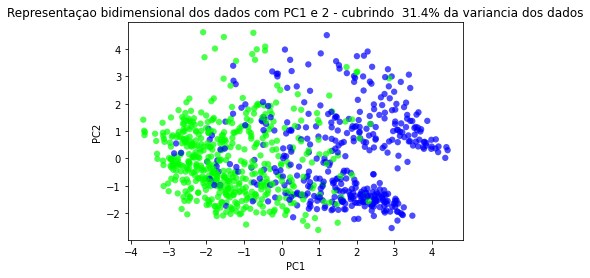

In [15]:
X_pca = PCA().fit_transform(x)

sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = y,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Representaçao bidimensional dos dados com PC1 e 2 - cubrindo {acc_variance[1]*100: .3}% da variancia dos dados")
plt.plot()

Os pontos em azul representam os pacientes que foram classificados como detentores de doenças cardíacas e os em verde os pacientes saudáveis. Desse modo, por mais que os PC's 1 e 2 só representem 31,4% das "informaçoes" dos dados, já é possível ver uma tendência dos clusters - entre os que apresentam doença no coraçao e os que nao apresentam.

Assim, podemos ver como performaria um algoritmo de clustering.

[]

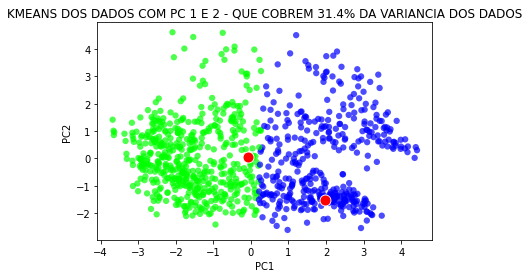

In [20]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_pca[:,:2])
labels = kmeans.labels_
centers = kmeans.cluster_centers_

sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = labels,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
sns.scatterplot(x = centers[0],y = centers[1], color = "red",alpha = 1,s = 120)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMEANS DOS DADOS COM PC 1 E 2 - QUE COBREM 31.4% DA VARIANCIA DOS DADOS")
plt.plot()

E, percebe-se que ,por mais que os PC's 1 e 2 cubram apenas 31.4% das informaçoes dos dados, o algoritmo de clustering K-means perfomou razoavelmente, chegando a clusters moderadamente semelhante aos clusters originais do dataset.

Porém, há um viés de facilidade na performance do K-means porque a quantidade desejada de clusters já é explicitada. Dessa maneira, um algoritmo de funcionamento diferente, como o DBSCAN poderia performar muito distintamente, que é o que será conferido em seguida.

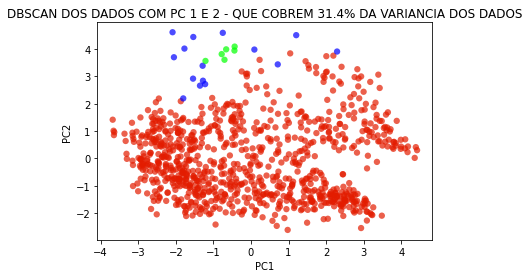

In [21]:
dbscan = DBSCAN()
dbscan.fit(X_pca[:,:2])
labels = dbscan.labels_

def plot_DBSCAN():
  sns.scatterplot(x = X_pca[:, 0],y = X_pca[:, 1],c = labels,edgecolor = 'none',alpha = 0.7,s = 40,cmap = plt.cm.get_cmap('brg', 10))
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title(f"DBSCAN DOS DADOS COM PC 1 E 2 - QUE COBREM 31.4% DA VARIANCIA DOS DADOS")
  plt.plot()

plot_DBSCAN()

Aqui percebe-se facilmente que o fato dos PC's 1 e 2 só cobrirem 31.4% das informaçoes dos dados nao permite que haja uma diferença clara e evidente entre os dados, de modo que dependendo do algoritmo utilizado, nao chega-se aos clusters desejados. Por mais que ,diante de algumas alteraçoes nas propriedades do algoritmo, pode-se aproximar levemente do esperado, demonstrado em seguida. 

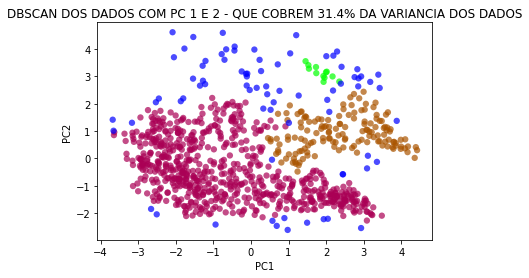

In [22]:
dbscan = DBSCAN(eps = 0.3, min_samples=5)
dbscan.fit(X_pca[:,:2])
labels = dbscan.labels_

plot_DBSCAN()

Portanto, com apenas 31.4% das informaçoes dos dados retidas nos PC's 1 e 2, percebe-se que nao há uma diferenciaçao devidamente explícita dos dados e que ,dessa maneira, os algoritmos de clustering performam insatisfatoriamente.
Assim, para que possamos prever - usando Logistic Regression - se o paciente possue ou nao doenças cardíacas com acurácia, devemos usar mais dimensoes do PCA. 

A acurácia do modelo foi de  86.781%.
A precisao do modelo foi de  90.625%.
O f1-score do modelo foi de  88.243%.


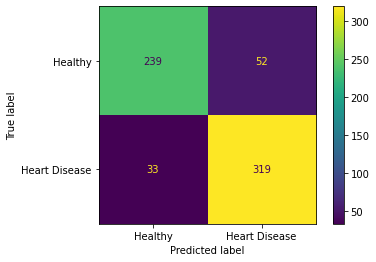

In [100]:
X_reduced = X_pca[:,:12]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, train_size = 0.3)

l_regression = LogisticRegression()
l_regression.fit(X_train, y_train)
y_pred = l_regression.predict(X_test)

accuracy = accuracy_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
f1 = f1_score(y_pred,y_test)

print(f"A acurácia do modelo foi de {accuracy*100: .5}%.")
print(f"A precisao do modelo foi de {precision*100: .5}%.")
print(f"O f1-score do modelo foi de {f1*100: .5}%.")

c_matrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=['Healthy','Heart Disease'])
cm.plot()